In [1]:
using QuadraticTeamDecisionSolver, Distributions, Statistics, LinearAlgebra, Plots, LaTeXStrings

In [2]:
#replace with desired directory
saveTo = "/home/fe/michelena/Schreibtisch/thesis/progress"

"/home/fe/michelena/Schreibtisch/thesis/progress"

In [3]:
N = 2;
σᵣ = 1.0;
p = QuadTeamProblem(N, N * N * ones(Int64, N), ones(Int64, N), ComplexF64);
t = teamMMSEproblem(σᵣ, zeros(Float64, N), ones(Float64, N), zeros(Float64, N), 0.5 * ones(Float64, N), 0.0 * ones(Float64, N));

In [4]:
function solver!(p,
    w,
    Y,
    R,
    r;
    iterations=10,
    h=1.5,
    λ=0.2)
    k(x, y; h=h) = exp((-norm(x-y)^2)/h) 
    regression(Y, X) = kernelInterpolation(k, Y, X, λ=λ)
    regressor(w, X, x) = kernelFunction(k, w, X, x)
    return empiricalJacobiSolver!(p, w, Y, R, r, regression, regressor, iterations=iterations)
end


solver! (generic function with 1 method)

In [5]:
m = 2000;
iterations = 10;
Y, R, r = generateTeamMMSEsamples(p, t, m);

In [6]:
m^(-2 / (2 + p.N*p.N))

0.07937005259840998

In [7]:
w_jacobi = [[rand(ComplexF64, m)] for _ in 1:p.N];
solver!(p, w_jacobi, Y, R, r);

In [8]:
conv_jacobi = [norm.(diff(w_jacobi[i])) for i in 1:p.N];

In [9]:
testR = reformatR(p.N, m, R);
testr = reformatr(p.N, m, r);
testW_jacobi = reformatU(p.N, m, iterations, w_jacobi);

In [10]:
perf_jacobi = [urisk(testW_jacobi[k], testR, testr) for k in 1:iterations]

10-element Vector{Float64}:
 3.1346558639917577
 0.2933234908463066
 0.14499132252251434
 0.09221193823475324
 0.0971725904445601
 0.0917912506310444
 0.0935897567907976
 0.09260307937743409
 0.09304092846594514
 0.09281277622850934

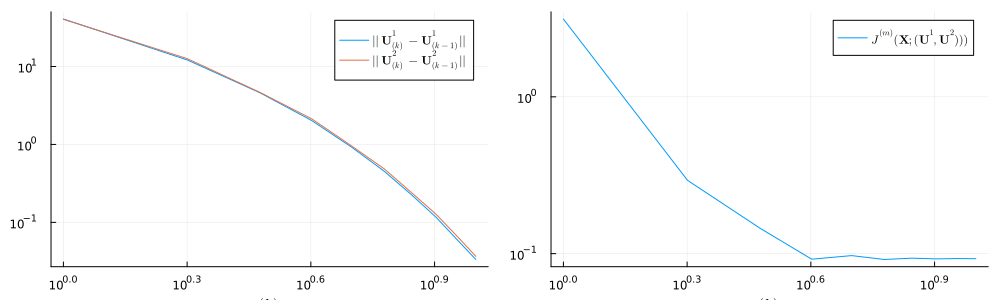

In [11]:
conv = plot(conv_jacobi, xscale=:log10, yscale=:log10, xlabel=L"(k)", label=[L"||\mathbf{U}_{(k)}^1 - \mathbf{U}_{(k-1)}^1||" L"||\mathbf{U}_{(k)}^2 - \mathbf{U}_{(k-1)}^2||"]);
perf = plot(perf_jacobi, yscale=:log10, xscale=:log10, xlabel=L"(k)", label=L"J^{(m)}(\mathbf{X}; (\mathbf{U}^1, \mathbf{U}^2)))");
plot(conv, perf, layout=(1, 2), size=(1000, 300))
savefig(saveTo*"/convergence.png");
display(Plots.current())

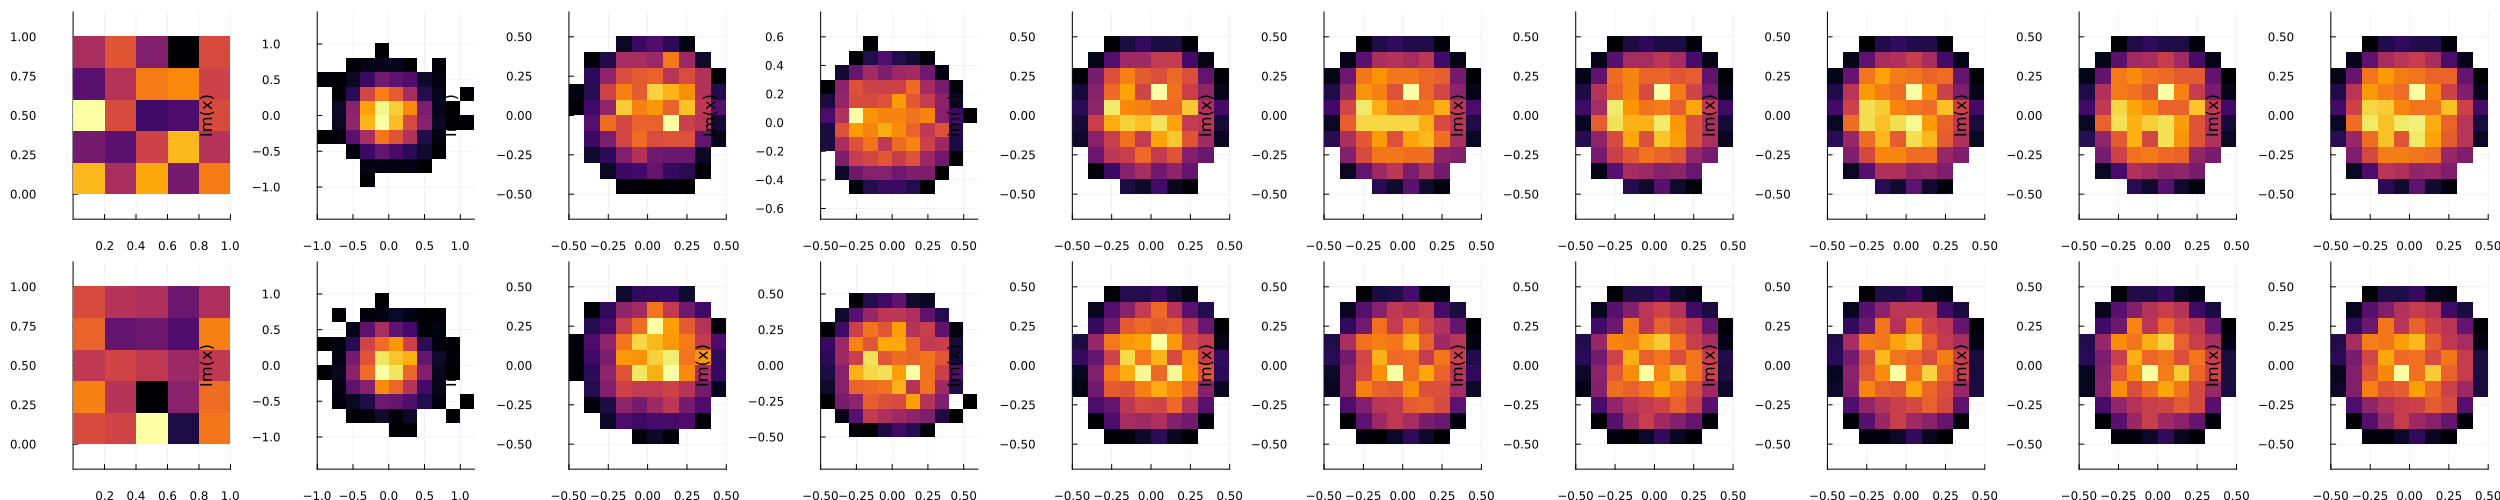

In [12]:
# Step 2: Create a 1x5 grid of subplots
plot_layout = plot(layout = (2, iterations), legend = false)

# Step 3: Generate histograms and add them to the grid
for k in 1:iterations
	h1 = histogram2d(
		w_jacobi[1][k],
		normalize = :pdf,
		show_empty_bins = false,
		normed = true,
		aspect_ratio = 1,
	)
	histogram2d!(
		plot_layout[k],
		w_jacobi[1][k],
		normalize = :pdf,
		show_empty_bins = false,
		normed = true,
		aspect_ratio = 1,
	)

	h2 = histogram2d(
		w_jacobi[2][k],
		normalize = :pdf,
		show_empty_bins = false,
		normed = true,
		aspect_ratio = 1,
	)
	histogram2d!(
		plot_layout[2, k],
		w_jacobi[2][k],
		normalize = :pdf,
		show_empty_bins = false,
		normed = true,
		aspect_ratio = 1,
	)
end

# Step 4: Show the plot
plot(plot_layout, size = (2500, 500))
savefig(saveTo*"/evolution.png");
display(Plots.current())

In [13]:
sinrRange = 10 .^ range(start = -10, stop = 10, length = 10);
sinrResult = [
	sinrExperiment(
		p,
		solver!,
		sinr;
		samples = 1000,
		iterations = 10,
		bandwidth = 1.5,
		regularizer = 0.2,
		eps = 0.0,
	) for sinr in sinrRange
];


In [14]:
sinrplt = plot(size=(700,500))
for (sinr, curve) in zip(sinrRange, sinrResult)
    plot!(sinrplt, curve, yscale=:log10, xscale=:log10, label=latexstring("\\sigma = $(sinr)"), legend=:topleft)

    # Get the last point of the current curve to place the label
    x_label = iterations
    y_label = last(curve)

    # Add the label on top of the curve
    annotate!(sinrplt, x_label, y_label, text(latexstring("\\sigma = $(sinr)"), 8, :left, :white, :black, 3))
end
savefig(saveTo*"/sinrplt.png");
display(Plots.current())

BoundsError: BoundsError: attempt to access Float64 at index [2]

In [15]:
sampleRange =  10 .^ range(start = 0, stop = 4, length = 10) .|> x -> round(Int64, x);
samplesResult = [samplesExperiment(
    p,
    solver!,
    samples;
    bandwidth = 0.5,
    iterations = 10,
    sinr = 1.5,
    regularizer = 0.2,
    eps = 0.0,
) for samples in sampleRange];


In [ ]:
interpolationError(p, m) = m^(-2 / (2 + p.N*p.N))
lowerErrorBound = [interpolationError(p, m) for m in sampleRange]

In [ ]:
sampleplt = plot(size=(700,500))
for (samples, curve, e) in zip(sampleRange, sampleResult, lowerErrorBound)
    plot!(sampleplt, curve, yscale=:log10, xscale=:log10, label=latexstring("m = $(samples)"), legend=:topleft)
    hline!([e])
end
savefig(saveTo*"/sampleplt.png");
display(Plots.current())